#Imports and functions

In [ ]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 15.2 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelBinarizer

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup

import re,string
import contractions

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
from wordcloud import WordCloud,STOPWORDS

from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import torch
import torch.nn as nn

import codecs
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import gensim.downloader as api

import os
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
def plot_top_frequency(data, count, title):
  '''
  Plot the most frequent words

  data (Series): data
  count (int): number of elements
  title (string): title for plot
  '''
  # Calculating word frequencies
  all_words = data.str.split(expand=True).unstack().value_counts()
  # Top words visualization
  fig, ax = plt.subplots(figsize=(12, 12))
  sns.barplot(x = all_words.values[:count],
              y = all_words.index.values[:count], ax=ax, orient='h').set(title=title)

  return all_words

In [ ]:
def build_model(model, gs_params, X_train, y_train, X_test, y_test):
  '''
  Train and test model with hyperparameters tuning and vizualization

  model (estimator): estimator instance
  gs_params (dict): parameters for GridSearchCV
  X_train, X_test (array-like of shape (n_samples, n_features)): inputs
  y_train, y_test (array-like of shape (n_samples,)): targets
  '''
  pipe = Pipeline([
    ('vector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', model())
  ])

  # Grid Search
  grid = GridSearchCV(pipe, param_grid=gs_params, scoring=make_scorer(roc_auc_score), cv=5, refit=True)
  grid.fit(X_train, y_train)

  print("Best score: ", grid.best_score_)
  print("Best parameters", grid.best_params_)

  # ROC-curve plotting
  rfc_disp = RocCurveDisplay.from_estimator(grid.best_estimator_, X_test, y_test)
  plt.show()

  disp = ConfusionMatrixDisplay.from_estimator(
    grid.best_estimator_,
    X_test,
    y_test,
    cmap=plt.cm.Blues,
    normalize='true',
  )
  disp.ax_.set_title('Confusion matrix')

  plt.show()

  return grid.best_estimator_

In [ ]:
def create_embedding_matrix(w_ind, embedding_dict=None, d=100):
  """
  Create the embedding matrix and return a numpy array with embedding vectors

  word_index (index): index value
  embedding_dict (dict): dictionary with word embedding
  d_model (int): dimension of word pretrained embedding
  """
  embedding_matrix = np.zeros((len(w_ind) + 1, d))
  for w, ind in w_ind.items():
    if w in embedding_dict:
      embedding_matrix[ind] = embedding_dict[w]
  return embedding_matrix

In [ ]:
def make_dataloader(X, y, batch_size, num_workers):
  '''
  Form dataloader using padding

  X: (array-like of shape (n_samples, n_features)): inputs
  y (array-like of shape (n_samples,)): targets
  batch_size (int): how many samples per batch to load
  num_workers: (int) - how many subprocesses to use for data loading
  '''
  # Pad sequence
  X = tokenizer.texts_to_sequences(X)
  X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

  dataset = ReviewDataset(reviews=X, targets=y)

  # Form Pytorch DataLoader
  data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

  return data_loader

In [ ]:
def train(data_loader, model, optimizer, device):
  """
  Train model during one epoch

  data_loader (Dataloader): torch dataloader
  model (class) : lstm
  optimizer (torch.optim) : torch optimizer
  device (device):  cuda or cpu
  """
  # Set the model to training mode
  model.train()
  train_loss = 0
  true_pred = 0
  total = 0

  for data in data_loader:
    reviews = data['review']
    targets = data['target']
    # Move the data to device
    reviews = reviews.to(device, dtype=torch.long)
    targets = targets.to(device, dtype=torch.float)
    # Zero the gradient
    optimizer.zero_grad()
    # Make predictions
    predictions = model(reviews)
    # Calculate the losses
    loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
    train_loss += loss.item()
    # Backprop
    loss.backward()
    # Optimization step
    optimizer.step()

    # Calculate accuracy
    predicted = torch.round(torch.sigmoid(predictions))
    total += targets.size(0)
    true_pred += (predicted == targets.view(-1,1)).sum().item()

  # calculate training loss and accuracy
  train_loss /= len(data_loader)
  train_accuracy = true_pred/total

  return train_loss, train_accuracy

In [ ]:
def evaluate(data_loader, model, device):
  """
  Validate model

  data_loader (Dataloader): torch dataloader
  model (class) : lstm
  device (device) : cuda or cpu
  """
  # Set model to evaluation mode
  model.eval()
  val_loss = 0
  true_pred = 0
  total = 0

  labels = []
  all_predictions = []

  with torch.no_grad():
    for data in data_loader:
      reviews = data['review']
      targets = data['target']
      # Move the data to device
      reviews = reviews.to(device, dtype=torch.long)
      targets = targets.to(device, dtype=torch.float)
      # Make predictions
      predictions = model(reviews)
      # Calculate the losses
      loss = nn.BCEWithLogitsLoss()(predictions, targets.view(-1,1))
      val_loss += loss.item()
      # Calculate accuracy
      predicted = torch.round(torch.sigmoid(predictions))

      all_predictions.append(predicted.cpu().numpy())
      labels.append(targets.cpu().numpy())

      total += targets.size(0)
      true_pred += (predicted == targets.view(-1,1)).sum().item()

  # Calculate validation loss and accuracy
  val_loss /= len(data_loader)
  val_accuracy = true_pred/total

  return val_loss, val_accuracy, labels, all_predictions

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
  """
  Plot learning curves for training and validation losses and accuracies

  train_losses, val_losses, train_accs, val_accs (array-like of shape (n_samples,)): train and validation losses and accuracies
  """
  plt.figure(figsize=(10, 4))

  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_accs, label='Training Accuracy')
  plt.plot(val_accs, label='Validation Accuracy')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

In [ ]:
def train_evaluate(X_train, y_train, X_val, y_val, embedding_matrix, checkpoint_filename, bidirectional=True):
    '''
    X_train, X_val (array-like of shape (n_samples, n_features)): inputs
    y_train, y_val (array-like of shape (n_samples,)): outputs
    embedding_matrix (ndarray) : matrix for pretrained embedding
    checkpoint_filename (string): title of file to save model
    bidirectional (bool): is lstm model bidirectional
    '''

    # Initialize lists to store losses and accuracies for each epoch and fold
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    train_data_loader = make_dataloader(X_train, y_train, TRAIN_BATCH_SIZE, 2)
    val_data_loader = make_dataloader(X_val, y_val, VAL_BATCH_SIZE, 1)

    device = torch.device('cuda')
    # Embedding matrix to lstm
    model_glove = Model(embedding_matrix)
    # Set model to device
    model_glove.to(device)
    # Optimizer
    optimizer = torch.optim.Adam(model_glove.parameters(), lr=1e-3)
    # Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Storing the best validation loss
    best_val_loss = float('inf')
    # The number of epochs since the last improvement in validation loss
    epochs_since_improvement = 0

    for epoch in range(EPOCHS):
        # Train
        train_loss, train_acc = train(train_data_loader, model_glove, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, _, _ = evaluate(val_data_loader, model_glove, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Check if validation loss has improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_since_improvement = 0

            # Save model checkpoint if validation loss has improved
            torch.save({
                'epoch': epoch,
                'model_state_dict': model_glove.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss
            }, checkpoint_filename)

        else:
            epochs_since_improvement += 1
            if epochs_since_improvement >= PATIENCE:
                print(f'Early stopping after {epoch} epochs')
                break

        # Adjust learning rate
        scheduler.step(val_loss)

        # Print learning curves after each epoch
        print(f'EPOCH: {epoch}, TRAIN LOSS: {train_loss:.4f}, VAL LOSS: {val_loss:.4f}, TRAIN ACC: {train_acc:.4f}, VAL ACC: {val_acc:.4f}')

    # Visualize learning curves
    plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
def test(X, y, model, device):
    """
    Test model

    X (array-like of shape (n_samples, n_features)): inputs
    y (array-like of shape (n_samples,)): outputs
    model (class) : lstm
    device (device) : cuda or cpu
    """

    X = X.reset_index()
    y = y.reset_index()

    data_loader = make_dataloader(X.review, y.sentiment, VAL_BATCH_SIZE, 1)
    device = torch.device('cuda')
    model.to(device)

    test_loss, test_accuracy, labels, all_predictions = evaluate(data_loader, model, device)

    print('TEST LOSS:', test_loss)
    print('TEST ACC:', test_accuracy)

    labels = [item for sublist in labels for item in sublist]
    all_predictions = [item for sublist in all_predictions for item in sublist]
    all_predictions = [item for sublist in all_predictions for item in sublist]

    disp = ConfusionMatrixDisplay.from_predictions(
      y_true=labels,
      y_pred=all_predictions,
      cmap=plt.cm.Blues,
      normalize='true',
    )
    disp.ax_.set_title('Confusion matrix')

    plt.show()

#EDA and preprocessing

##Importing dataset

Dataset info:

This is a dataset for binary sentiment classification. We provide a set of 50,000 highly polar movie reviews for training and testing.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/LargeMovieReviewDataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

So we see that our dataset contains 50000 records and 2 columns: review and sentiment.

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


There are 49582/50000 unique reviews.

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Our dataset is balanced: each target class is represented by the same number of input samples (25000).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Is seems there are no null values in the dataset.

##Cleaning and tokenization

Let's take a look at one review from our dataset:

In [ ]:
df['review'][45]

"As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the musical :) ) <br /><br />I actually believe Michael Douglas worked quite well in that role, along with Kasey. I think her 'Let me dance for you scene' is one of the best parts of the movie, a worthwhile addition compared to the musical. The dancers and singing in the movie are much superior to the musical, as well as the cast which is at least 10 times bigger (easier to do in the movie of course). The decors, lighting, dancing, and singing are also much superior in the movie, which should be expected, and was indeed delivered. <br /><br />The songs that were in common with the musical are better done in the movie, the new ones are quite good ones, and the whole movie just delivers more than the musical in my opinion, especially compared to 

First I'd like to reduce the noise in the data: remove/transform some parts of the text using regular expressions to make the text more understandable for future models. I'll remove html tags, brackets, links, punctuation, etc. Also, since the subject of our research is movie reviews, I'd expect emojis to be there. I'll separate the emojis into positive and negative ones and replace them with the words 'emopos' and 'emoneg' respectively. Since there is informal speech in the text, I will deal with the repetition of letters as well.

In [ ]:
def replace_emoji(text):

  ''' Replacing emojis with words that separate positive and negative ones '''

  # smile -- :), : ), :-), (:, ( :, (-:, :')
  text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' emopos ', text)
  # laugh -- :D, : D, :-D, xD, x-D, XD, X-D
  text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' emopos ', text)
  # love -- <3, :*
  text = re.sub(r'(<3|:\*)', ' emopos ', text)
  # wink -- ;-), ;), ;-D, ;D, (;,  (-;
  text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' emopos ', text)
  # sad -- :-(, : (, :(, ):, )-:
  text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' emoneg ', text)
  # cry -- :,(, :'(, :"(
  text = re.sub(r'(:,\(|:\'\(|:"\()', ' emoneg ', text)

  return text


def remove_html(text):

  ''' Removing html tags '''

  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()


def clean_text(text):
  # removing html
  text = remove_html(text)

  # removing square brackets
  text = re.sub('\[[^]]*\]', ' ', text)

  # replacing contractions
  text = contractions.fix(text)

  # replacing emoji
  text = replace_emoji(text)

  # removing links
  text = re.sub('https?://\S+|www\.\S+', ' ', text)

  # removing text in angle brackets
  text = re.sub('<.*?>+', ' ', text)

  # removing punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

  # removing words with digits
  text = re.sub('\w*\d\w*', ' ', text)

  # removing special characters
  text=re.sub('[^a-zA-z0-9\s]',' ',text)

  # replacing more than one space with one space
  text = re.sub(' +', ' ', text)

  # replacing more than 2 letter repetitions with 2 letters
  text = re.sub(r'(.)\1+', r'\1\1', text)

  # converting text to lower case
  text = text.lower()

  return text

Let's apply the function for cleaning the text on review column.

In [ ]:
df['cleaned']=df['review'].apply(clean_text)

In the next step, I'll tokenize the text using `ToktokTokenizer` to break text into chunks and remove the stopwords using `nltk.corpus.stopwords`.

In [ ]:
# Tokenizer
tokenizer=ToktokTokenizer()
# Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
stopword_list.remove('not')

In [ ]:
stop=set(nltk.corpus.stopwords.words('english'))

# Removing the stopwords
def remove_stopwords(text, stop, is_lower_case=False):

    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]

    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Applying the function
df['cleaned']=df['cleaned'].apply(remove_stopwords, stop=stop)

##Normalisation

Now we should normalize the dataset. We'll perform stemming (using `PorterStemmer`) and look at the results. In order to optimize and reduce the execution time, I'll use data caching (dictionary `CACHE_STEMS`).

In [ ]:
CACHE_STEMS = {}

# Stemmer initialization
pstemmer=nltk.porter.PorterStemmer()

# Word stemming
def stemm(word):
    if word in CACHE_STEMS:
      return CACHE_STEMS[word]
    stem = pstemmer.stem(word)
    CACHE_STEMS[word] = stem
    return stem

I'll add text after stemming to initial dataset. To speed up the search for words, I'll also create a set of words.

In [ ]:
# Set of words and lists for initial words, lemmatized words and stemmed words
words_set = set()
words = []
stems = []


# Text normalization
def normalize(text):
  stems_res = []

  for word in text.split():

    stem = stemm(word)

    stems_res.append(stem)

    if word not in words_set:
      words_set.add(word)
      words.append(word)
      stems.append(stem)

  return pd.Series([' '.join(stems_res)])

# Applying the function
df['stem'] = df['cleaned'].apply(normalize)

##Labeling

Let's encode the target feature.

In [ ]:
lb=LabelBinarizer()
df['sentiment']=lb.fit_transform(df['sentiment'])

##X and y datasets

Now we can create train and test datasets. I'll use the results of stemming, cleaning and data without preprocessing.

In [ ]:
X_train_stem, X_test_stem, y_train, y_test = train_test_split(df['stem'], df['sentiment'], test_size=0.1, random_state=42, stratify=df['sentiment'])
X_train_clean, X_test_clean = train_test_split(df['cleaned'], test_size=0.1, random_state=42, stratify=df['sentiment'])
X_train_raw, X_test_raw = train_test_split(df['review'], test_size=0.1, random_state=42, stratify=df['sentiment'])

##Word analyzing

Let's visualize top 30 words for positive reviews.

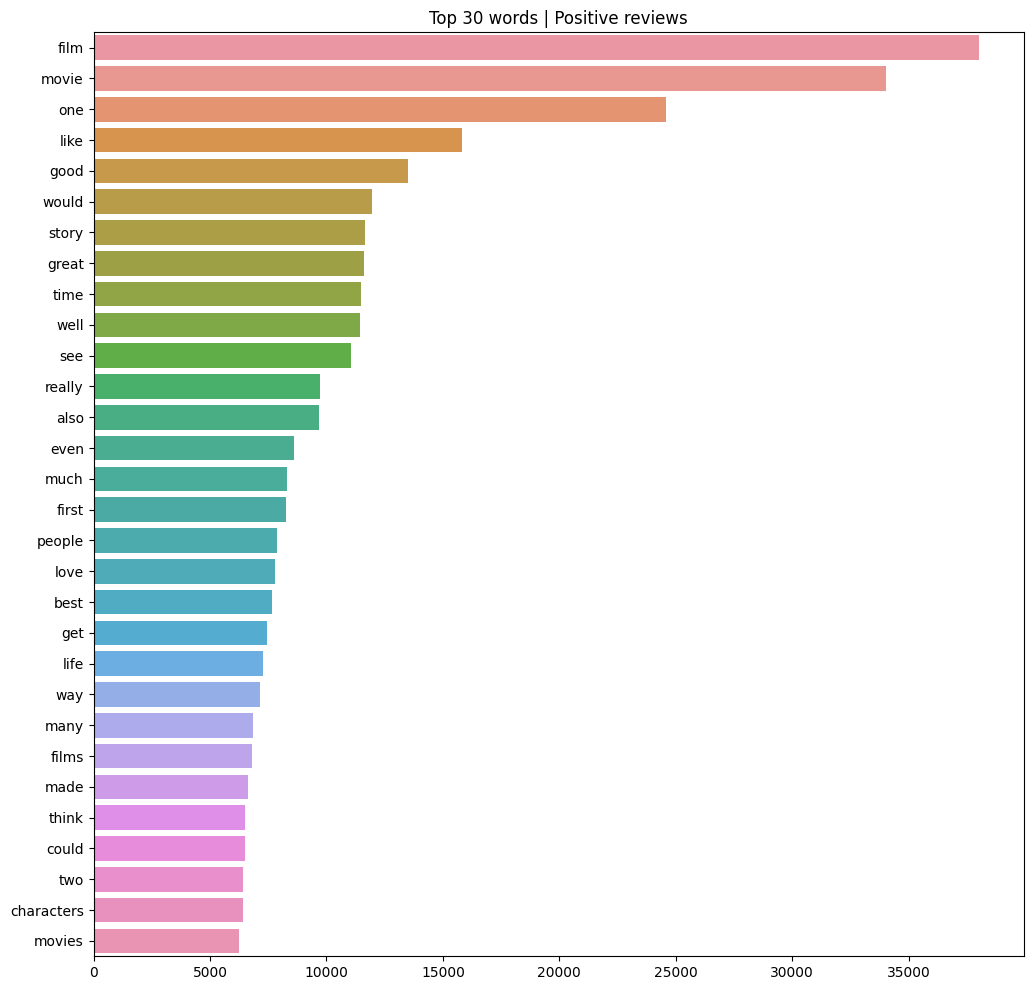

In [ ]:
pos_words = plot_top_frequency(X_train_clean[y_train == 1], 30, 'Top 30 words | Positive reviews')

Now let's take a look at top 30 words for negative reviews.

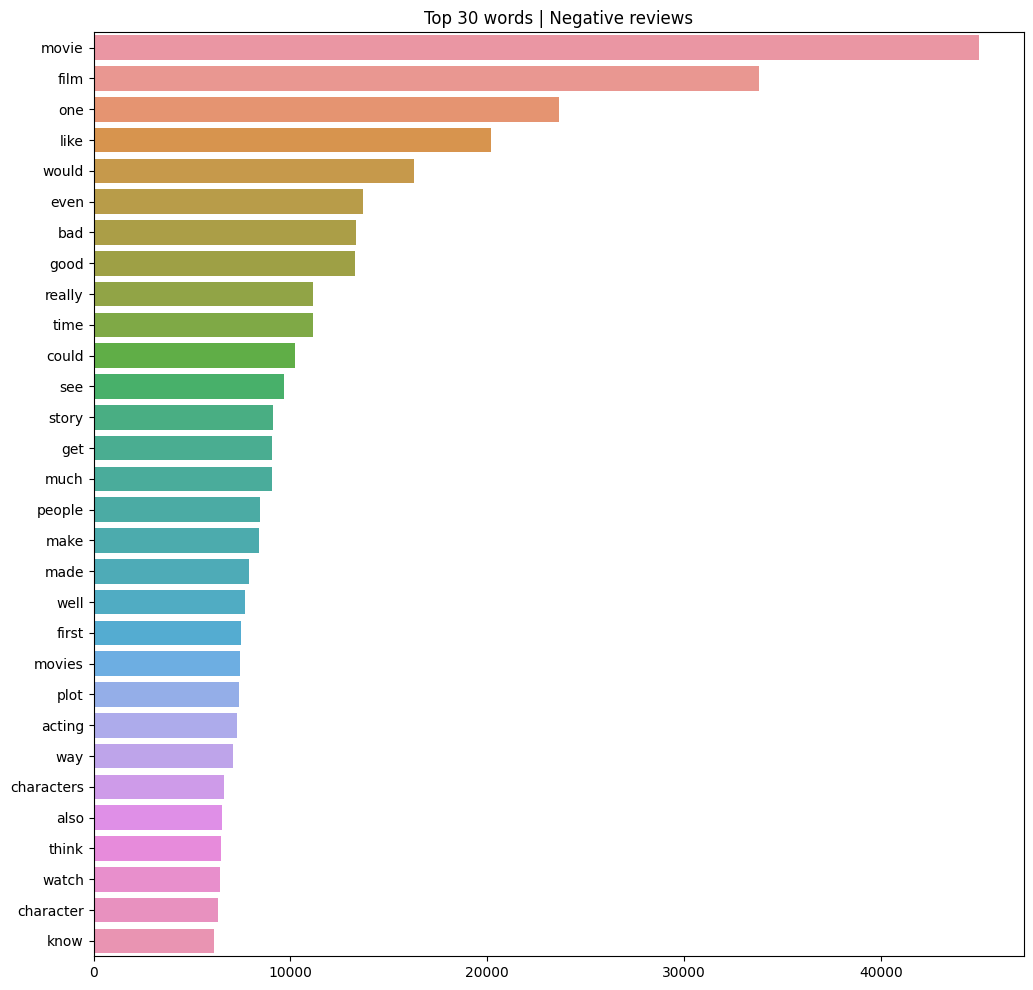

In [ ]:
neg_words = plot_top_frequency(X_train_clean[y_train == 0], 30, 'Top 30 words | Negative reviews')

There are a many words that are popular in both classes, e.g. 'movi', 'film', 'one', 'like'. People seem to use the word 'good' in negative reviews as often as they use the word 'bad'. Although, it seems that people use 'movie' more often in the negative class, I can't say all these words are important for classification.

Now I'd like to form the table of word frequencies.

In [ ]:
freq = pd.concat([neg_words, pos_words], axis=1)
freq

,0,1
movie,45011.0,34016.0
film,33812.0,38034.0
one,23658.0,24585.0
like,20218.0,15808.0
would,16296.0,11953.0
...,...,...
summerlee,NaN,1.0
lulllillielilla,NaN,1.0
lacksidaisical,NaN,1.0
walthal,NaN,1.0


And vizualize the top 30 words.

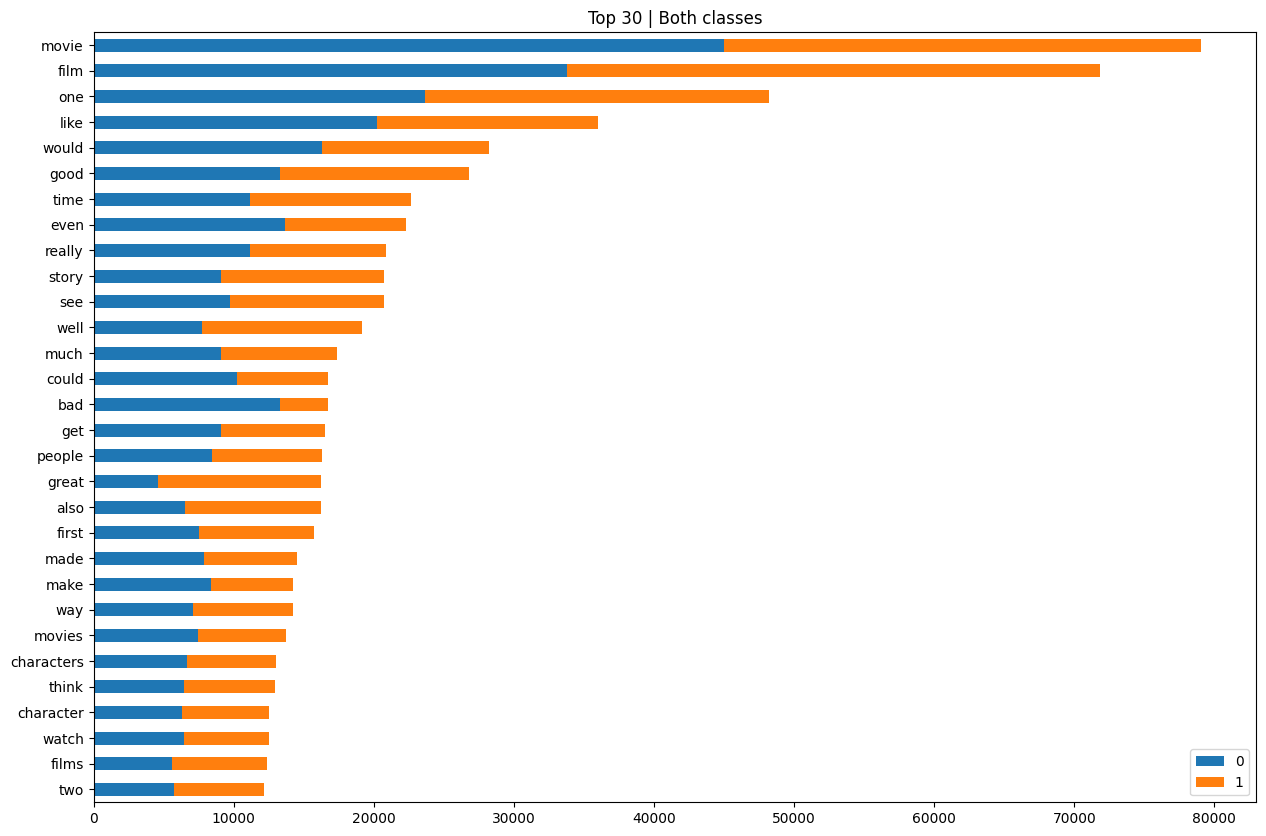

In [ ]:
top60_by_neg = freq.iloc[:60]
top30 = top60_by_neg.loc[(top60_by_neg[0] + top60_by_neg[1]).sort_values().index][30:]
top30.plot.barh(figsize=(15, 10), stacked=True)
plt.title('Top 30 | Both classes')
plt.show()

Now we can see that the word 'bad' is more common among negative reviews and words 'love' and 'well' are more common among positive ones.

Let's take a look at the words that are quite popular and have the biggest difference between appearing in negative and positive classes. First I'll take top 1000 most frequent words and then sort them by percentage ratio of positive class to negative.

In [ ]:
top1000 = freq.iloc[:1000]
top1000["cmp"] = (top1000[1] / top1000[0] * 100)
top1000.sort_values(by="cmp", inplace=True, ascending=False)
top1000.head(10)

,0,1,cmp
wonderful,496.0,2381.0,480.040323
excellent,674.0,3022.0,448.367953
amazing,472.0,1827.0,387.076271
brilliant,490.0,1675.0,341.836735
perfect,637.0,2167.0,340.188383
loved,622.0,2035.0,327.170418
favorite,496.0,1617.0,326.008065
highly,529.0,1523.0,287.901701
today,580.0,1656.0,285.517241
beautiful,1052.0,2724.0,258.935361


Now we see that the most important words for a positive class are: 'excel', 'perfect', 'brilliant', 'favorit', 'amaz', etc.

Let's take a look at the most important words for a negative class.

In [ ]:
top1000.sort_values(by="cmp", ascending=True).head(10)

,0,1,cmp
waste,2337.0,154.0,6.589645
redeeming,510.0,46.0,9.019608
worst,4415.0,411.0,9.309173
awful,2825.0,266.0,9.415929
poorly,1137.0,115.0,10.114336
laughable,670.0,71.0,10.597015
pointless,793.0,95.0,11.979823
sucks,498.0,63.0,12.650602
lame,1102.0,150.0,13.611615
wasted,916.0,129.0,14.082969


Well, that's more like it.

I'd like to exclude from X datasets words that have a close number of occurrences in both classes and form "reduced" datasets.

In [ ]:
top = freq
top["cmp"] = (top[1] / top[0] * 100)
words_to_exclude = top[(top['cmp'] > 85) & (top['cmp'] < 115)]
words_to_exclude

,0,1,cmp
film,33812.0,38034.0,112.486691
one,23658.0,24585.0,103.918336
good,13296.0,13502.0,101.549338
really,11157.0,9701.0,86.949897
time,11147.0,11491.0,103.086032
...,...,...,...
odeon,1.0,1.0,100.000000
pastors,1.0,1.0,100.000000
isaak,1.0,1.0,100.000000
marshalls,1.0,1.0,100.000000


In [ ]:
words_to_exclude_set=set(words_to_exclude.index)

# Applying the function of removing stopwords
X_train_reduced=X_train_clean.apply(remove_stopwords, stop=words_to_exclude_set)
X_test_reduced=X_test_clean.apply(remove_stopwords, stop=words_to_exclude_set)

Now let's create wordclouds for positive and negative words.

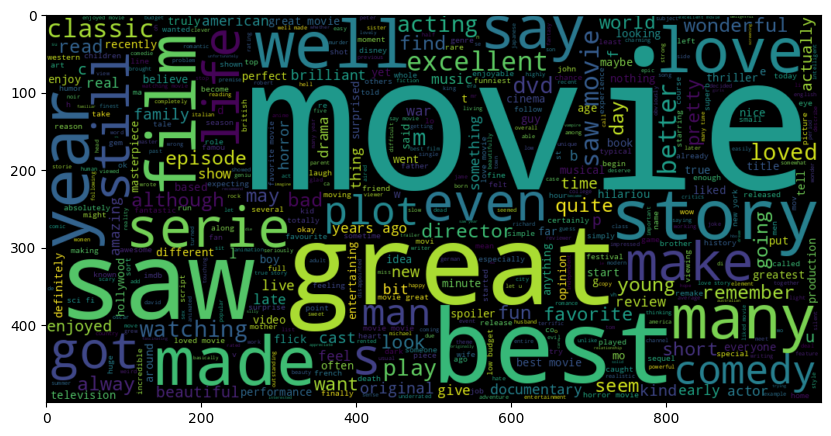

In [ ]:
# Word cloud for positive review words
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(X_train_reduced[y_train==1].to_string())
plt.imshow(positive_words,interpolation='bilinear')
plt.show()

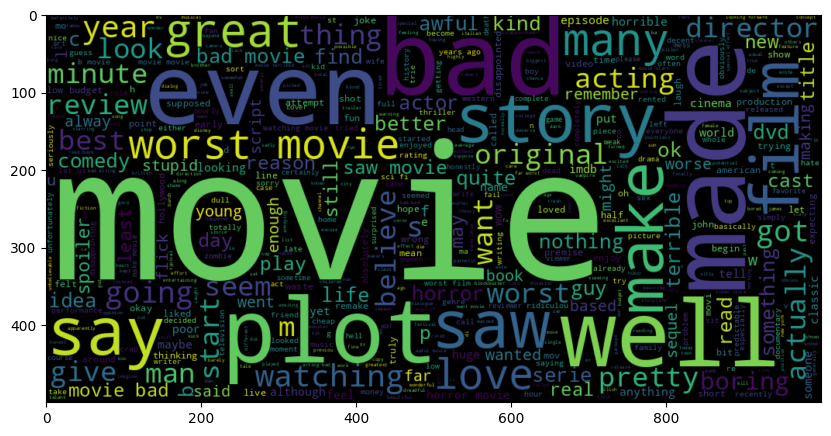

In [ ]:
# Word cloud for positive review words
plt.figure(figsize=(10,10))
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(X_train_reduced[y_train==0].to_string())
plt.imshow(negative_words,interpolation='bilinear')
plt.show()

#Models

##Baseline

Now we can move on to the models. I'll use `CountVectorizer` to convert a text data to a matrix of token counts. Then I'll use `TfidfTransformer` to transform a count matrix to a tf-idf representation. The goal is to reduce the impact of tokens that are very common in a corpus and therefore less informative than features that occur in a small part of the corpus.

I'll perform `GridSearchCV` to find the best parameters. As a cross-validation splitting strategy, I'll use `StratifiedKFold` with 5 folds to ensure that the cross-validation result is a close approximation of generalization error. As a scorer, I'll use `roc_auc_score` since the dataset is balanced. I'll also use confusion matrix to look at the results. To visualize the tradeoff between true positive rate and false positive rate, `RocCurveDisplay` will be used.

First I'll try the model on data after stemming.

Best score:  0.8925777777777778
Best parameters {'model__C': 10}


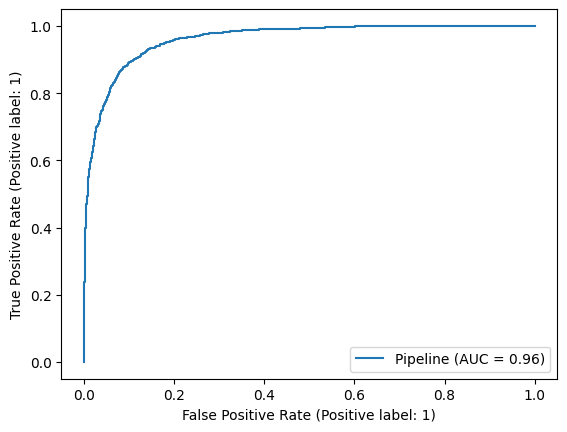

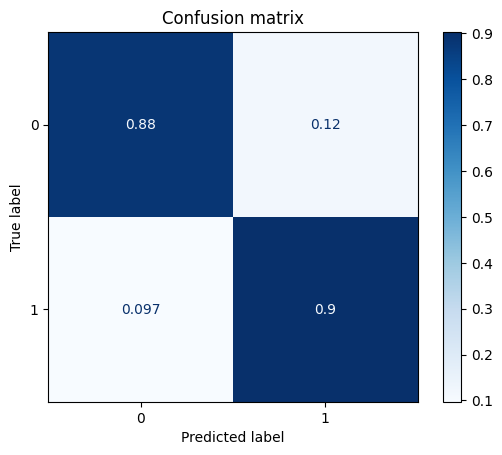

CPU times: user 4min 16s, sys: 5min 12s, total: 9min 29s
Wall time: 4min 19s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(C=10))])

In [ ]:
%%time

parameters_nb = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

build_model(LogisticRegression, parameters_nb, X_train_stem, y_train, X_test_stem, y_test)

Next I'll try the model on data after cleaning.

Best score:  0.8976222222222223
Best parameters {'model__C': 10}


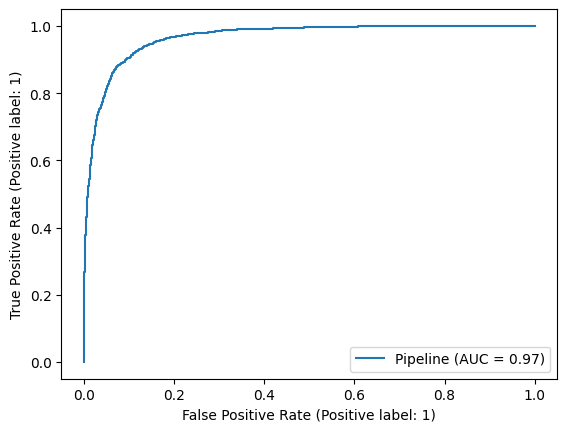

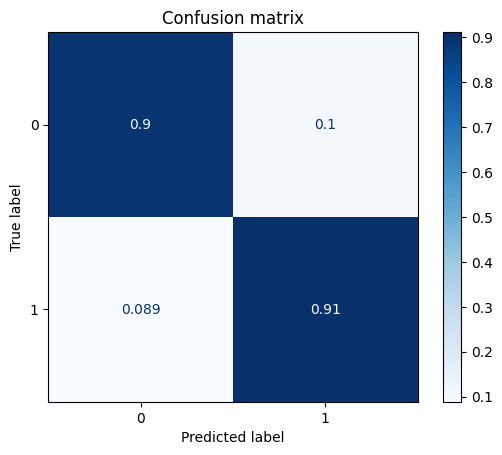

CPU times: user 5min, sys: 6min 23s, total: 11min 24s
Wall time: 4min 53s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(C=10))])

In [ ]:
%%time

build_model(LogisticRegression, parameters_nb, X_train_clean, y_train, X_test_clean, y_test)

Next model on data without preprocessing.

Best score:  0.8996666666666666
Best parameters {'model__C': 10}


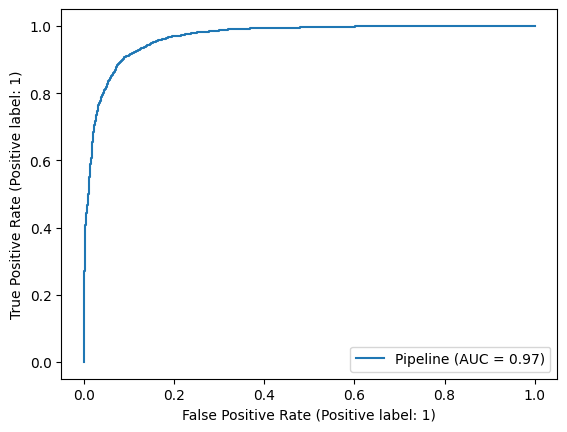

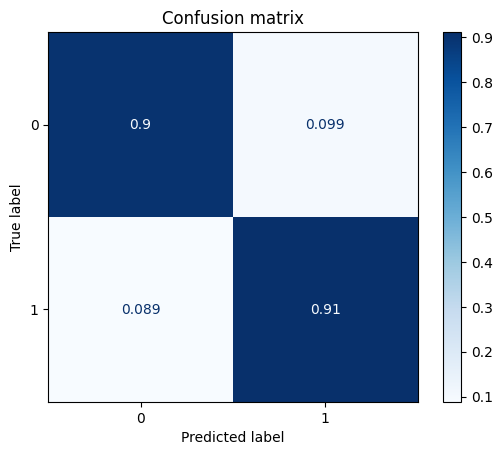

CPU times: user 7min 48s, sys: 8min 29s, total: 16min 17s
Wall time: 7min 53s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(C=10))])

In [ ]:
%%time

build_model(LogisticRegression, parameters_nb, X_train_raw, y_train, X_test_raw, y_test)

And the last one on reduced dataset.

Best score:  0.8975777777777777
Best parameters {'model__C': 10}


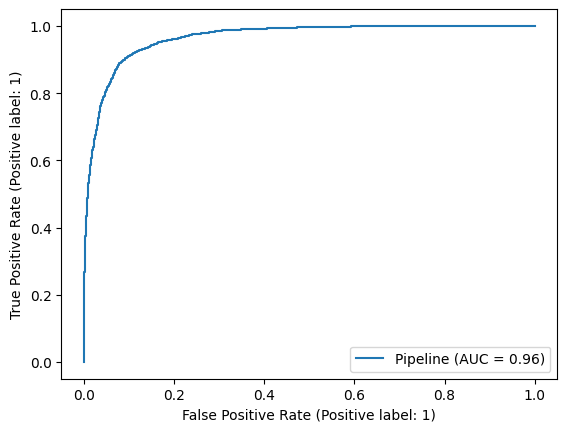

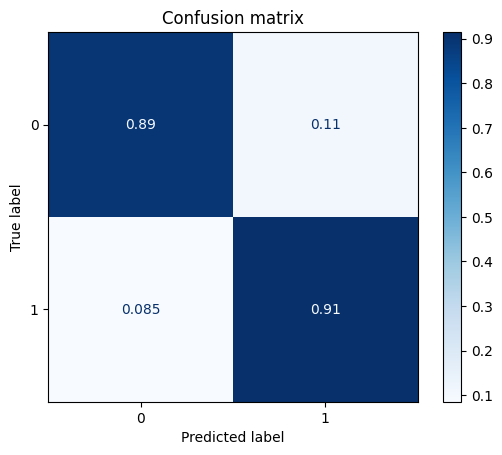

CPU times: user 3min 53s, sys: 4min 46s, total: 8min 39s
Wall time: 3min 47s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LogisticRegression(C=10))])

In [ ]:
%%time

build_model(LogisticRegression, parameters_nb, X_train_reduced, y_train, X_test_reduced, y_test)

All the models have the accuracy 89-90%. The model trained on raw data turned out to be a little better than others. We see that in this case the pre-processing steps do not have a significant impact on the performance of this linear model.

I'll use datasets without preprocessing for futher work.

##RNN

To use embedding we have to load pre-trained FastText and Glove word embeddings.

In [ ]:
print('loading word embeddings...')
fasttext_embedding = {}
f = codecs.open('/content/gdrive/MyDrive/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    w = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fasttext_embedding[w] = coefs
f.close()

loading word embeddings...


999995it [01:11, 13986.03it/s]


In [ ]:
glove = pd.read_csv('/content/gdrive/MyDrive/glove.6B.300d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

Now I'd like to create the class that represents the reviews with sentiments.

In [ ]:
class ReviewDataset:
  def __init__(self, reviews, targets):
    """
    reviews (numpy array)
    targets (vector array)
    """
    self.reviews = reviews
    self.target = targets

  def __len__(self):
    # Length of dataset
    return len(self.reviews)

  def __getitem__(self, index):
    # Review and target of given index in torch tensor
    review = torch.tensor(self.reviews[index,:], dtype = torch.long)
    target = torch.tensor(self.target[index], dtype = torch.float)

    return {'review': review,
            'target': target}

And a class for model with input embedding layer, LSTM (one- or bidirectional) and output linear layer.

In [ ]:
class Model(nn.Module):
  def __init__(self, embedding_matrix, bidirectional=True):
    """
    embedding_matrix: numpy array with vector for all words
    bidirectional (bool): is lstm model bidirectional
    """
    super(Model, self).__init__()
    # Define an input embedding layer
    self.emb = nn.Embedding(
                                  num_embeddings=embedding_matrix.shape[0],
                                  embedding_dim=embedding_matrix.shape[1])
    # Use embedding matrix and switch requires_grad to false to use pretrained embedding
    self.emb.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype = torch.float32))
    self.emb.weight.requires_grad = False
    # Model
    self.lstm = nn.LSTM(
                        embedding_matrix.shape[1],
                        128,
                        bidirectional=bidirectional,
                        batch_first=True,
                          )
    if bidirectional:
      self.out = nn.Linear(512, 1)
    else:
      self.out = nn.Linear(256, 1)

  def forward(self, x):
    x = self.emb(x)
    hid, _ = self.lstm(x)
    max, _ = torch.max(hid, 1)
    avg = torch.mean(hid, 1)
    out = torch.cat((max, avg), 1)
    out = self.out(out)
    return out

Hyperparameters for the model:

In [ ]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 16
VAL_BATCH_SIZE = 16
EPOCHS = 10
PATIENCE = 2

Now I'll split training data into train and validation datasets.

In [ ]:
X_train_raw_nn, X_val_raw_nn, y_train_nn, y_val_nn  = train_test_split(X_train_raw, y_train, test_size=0.1, random_state=42)
X_train_clean_nn, X_val_clean_nn = train_test_split(X_train_clean, test_size=0.1, random_state=42)
X_train_stem_nn, X_val_stem_nn = train_test_split(X_train_stem, test_size=0.1, random_state=42)

And fit the tokenizer on the training data.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_raw_nn.values.tolist())

###Word2Vec

First I create embedding matrix.

In [ ]:
w2v_model = api.load("word2vec-google-news-300")

embedding_matrix = create_embedding_matrix(tokenizer.word_index, w2v_model, 300)

Now we can train the model on data without preprocessing. First I'll try 1-directional LSTM.

EPOCH: 0, TRAIN LOSS: 0.3703, VAL LOSS: 0.3410, TRAIN ACC: 0.8320, VAL ACC: 0.8478
EPOCH: 1, TRAIN LOSS: 0.2746, VAL LOSS: 0.2902, TRAIN ACC: 0.8851, VAL ACC: 0.8729
EPOCH: 2, TRAIN LOSS: 0.2302, VAL LOSS: 0.2688, TRAIN ACC: 0.9068, VAL ACC: 0.8818
EPOCH: 3, TRAIN LOSS: 0.1902, VAL LOSS: 0.2666, TRAIN ACC: 0.9263, VAL ACC: 0.8896
EPOCH: 4, TRAIN LOSS: 0.1493, VAL LOSS: 0.2735, TRAIN ACC: 0.9467, VAL ACC: 0.8878
Early stopping after 5 epochs


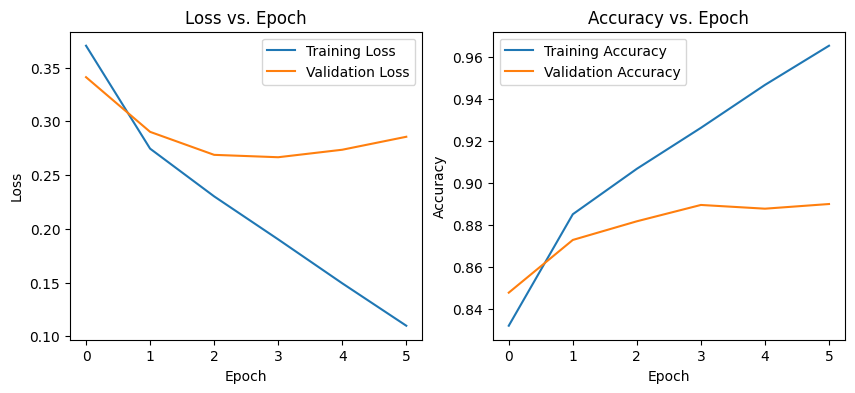

In [ ]:
train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_word2vec_1d.pt', bidirectional=False)

I'd like to try the model on data after cleaning and stemming.

EPOCH: 0, TRAIN LOSS: 0.4006, VAL LOSS: 0.3421, TRAIN ACC: 0.8156, VAL ACC: 0.8531
EPOCH: 1, TRAIN LOSS: 0.3107, VAL LOSS: 0.3238, TRAIN ACC: 0.8672, VAL ACC: 0.8618
EPOCH: 2, TRAIN LOSS: 0.2615, VAL LOSS: 0.3227, TRAIN ACC: 0.8926, VAL ACC: 0.8671
EPOCH: 3, TRAIN LOSS: 0.2082, VAL LOSS: 0.3332, TRAIN ACC: 0.9218, VAL ACC: 0.8656
Early stopping after 4 epochs


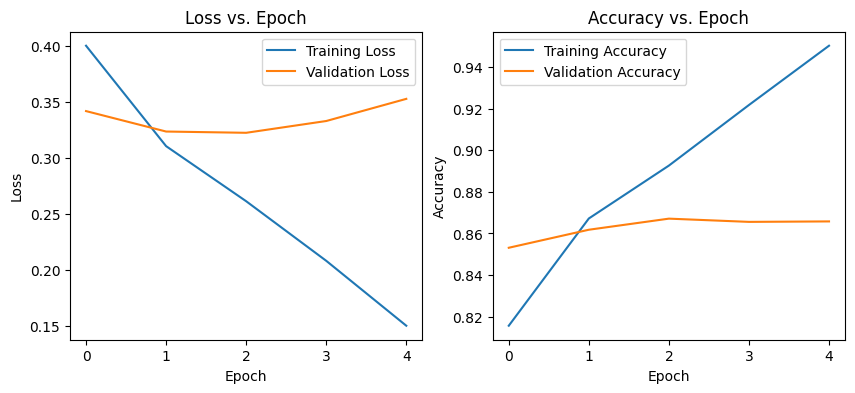

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_stem_nn.values.tolist())

train_evaluate(X_train_stem_nn, y_train_nn.values, X_val_stem_nn, y_val_nn.values, embedding_matrix, 'model_word2vec_1d.pt', bidirectional=False)

After only cleaning.

EPOCH: 0, TRAIN LOSS: 0.4565, VAL LOSS: 0.3585, TRAIN ACC: 0.7798, VAL ACC: 0.8429
EPOCH: 1, TRAIN LOSS: 0.3067, VAL LOSS: 0.3262, TRAIN ACC: 0.8715, VAL ACC: 0.8602
EPOCH: 2, TRAIN LOSS: 0.2359, VAL LOSS: 0.3191, TRAIN ACC: 0.9084, VAL ACC: 0.8649
EPOCH: 3, TRAIN LOSS: 0.1719, VAL LOSS: 0.3239, TRAIN ACC: 0.9429, VAL ACC: 0.8624
Early stopping after 4 epochs


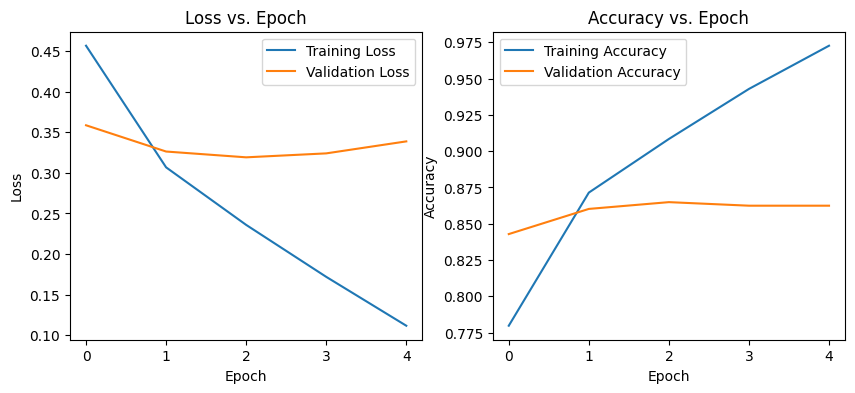

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_clean_nn.values.tolist())

train_evaluate(X_train_clean_nn, y_train_nn.values, X_val_clean_nn, y_val_nn.values, embedding_matrix, 'model_word2vec_1d.pt', bidirectional=False)

Data without preprocessing shows better results. I'll use it for future models.

Now I can try 2-directional LSTM.

EPOCH: 0, TRAIN LOSS: 0.3691, VAL LOSS: 0.3094, TRAIN ACC: 0.8316, VAL ACC: 0.8644
EPOCH: 1, TRAIN LOSS: 0.2740, VAL LOSS: 0.2788, TRAIN ACC: 0.8858, VAL ACC: 0.8811
EPOCH: 2, TRAIN LOSS: 0.2278, VAL LOSS: 0.2676, TRAIN ACC: 0.9072, VAL ACC: 0.8851
EPOCH: 3, TRAIN LOSS: 0.1904, VAL LOSS: 0.2697, TRAIN ACC: 0.9269, VAL ACC: 0.8880
Early stopping after 4 epochs


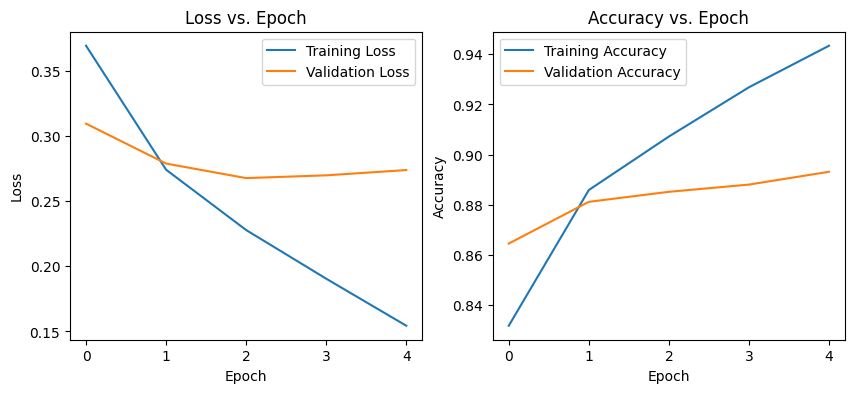

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_raw_nn.values.tolist())

train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_word2vec_2d.pt')

###GloVe

Next pretrained embedding - GloVe.

1-directional LSTM:

EPOCH: 0, TRAIN LOSS: 0.3512, VAL LOSS: 0.2989, TRAIN ACC: 0.8426, VAL ACC: 0.8689
EPOCH: 1, TRAIN LOSS: 0.2505, VAL LOSS: 0.2724, TRAIN ACC: 0.8956, VAL ACC: 0.8851
EPOCH: 2, TRAIN LOSS: 0.1870, VAL LOSS: 0.2727, TRAIN ACC: 0.9275, VAL ACC: 0.8911
Early stopping after 3 epochs


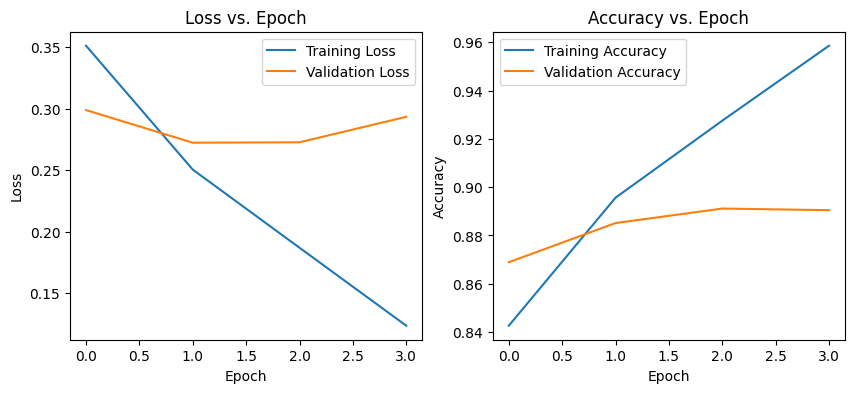

In [ ]:
embedding_matrix = create_embedding_matrix(tokenizer.word_index, glove_embedding, 300)

train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_glove_1d.pt', bidirectional=False)

Bidirectional LSTM:

EPOCH: 0, TRAIN LOSS: 0.3512, VAL LOSS: 0.2951, TRAIN ACC: 0.8421, VAL ACC: 0.8678
EPOCH: 1, TRAIN LOSS: 0.2495, VAL LOSS: 0.2731, TRAIN ACC: 0.8968, VAL ACC: 0.8787
EPOCH: 2, TRAIN LOSS: 0.1837, VAL LOSS: 0.2740, TRAIN ACC: 0.9304, VAL ACC: 0.8829
Early stopping after 3 epochs


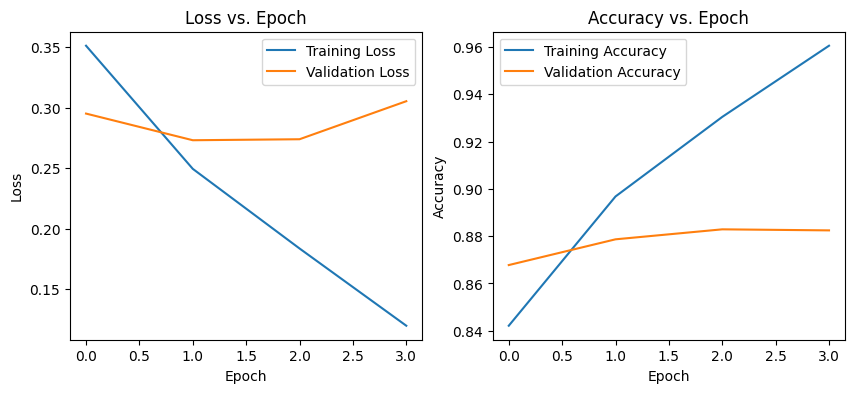

In [ ]:
train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_glove_2d.pt')

###FastText

1-directional LSTM:

EPOCH: 0, TRAIN LOSS: 0.3689, VAL LOSS: 0.3146, TRAIN ACC: 0.8323, VAL ACC: 0.8640
EPOCH: 1, TRAIN LOSS: 0.2694, VAL LOSS: 0.2724, TRAIN ACC: 0.8880, VAL ACC: 0.8796
EPOCH: 2, TRAIN LOSS: 0.2237, VAL LOSS: 0.2636, TRAIN ACC: 0.9100, VAL ACC: 0.8849
EPOCH: 3, TRAIN LOSS: 0.1827, VAL LOSS: 0.2666, TRAIN ACC: 0.9296, VAL ACC: 0.8882
Early stopping after 4 epochs


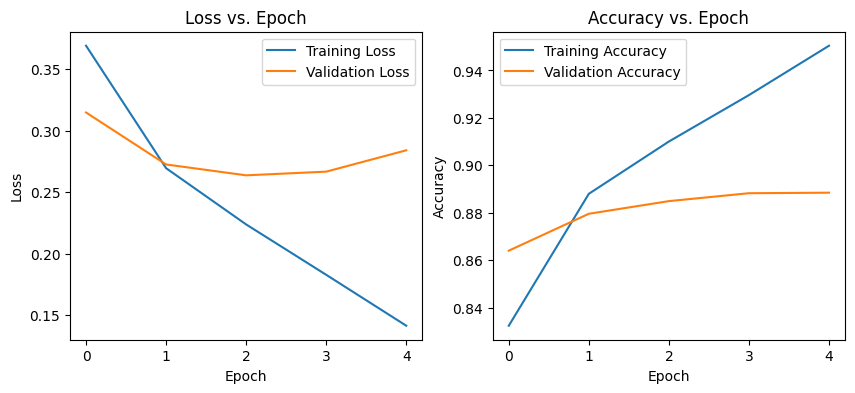

In [ ]:
embedding_matrix = create_embedding_matrix(tokenizer.word_index, fasttext_embedding, 300)

train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_fasttext_1d.pt', bidirectional=False)

Bidirectional LSTM:

EPOCH: 0, TRAIN LOSS: 0.3871, VAL LOSS: 0.3324, TRAIN ACC: 0.8216, VAL ACC: 0.8576
EPOCH: 1, TRAIN LOSS: 0.2791, VAL LOSS: 0.2800, TRAIN ACC: 0.8825, VAL ACC: 0.8784
EPOCH: 2, TRAIN LOSS: 0.2313, VAL LOSS: 0.2657, TRAIN ACC: 0.9055, VAL ACC: 0.8860
EPOCH: 3, TRAIN LOSS: 0.1895, VAL LOSS: 0.2689, TRAIN ACC: 0.9264, VAL ACC: 0.8847
Early stopping after 4 epochs


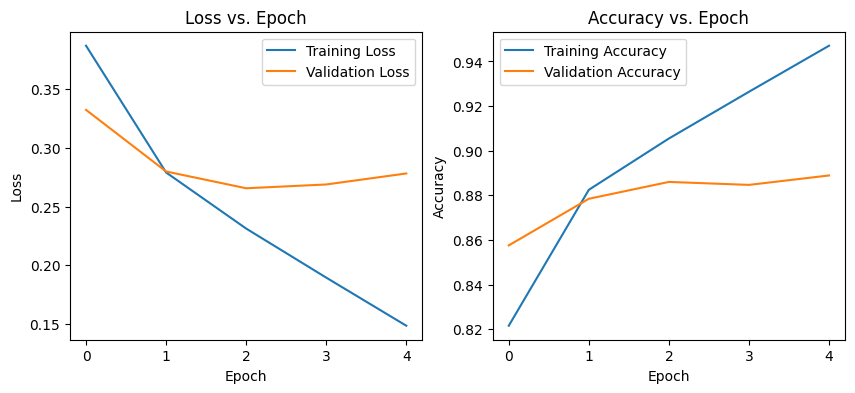

In [ ]:
train_evaluate(X_train_raw_nn, y_train_nn.values, X_val_raw_nn, y_val_nn.values, embedding_matrix, 'model_fasttext_2d.pt')

#Test

I'll pick one model for testing the model on test data.

In [ ]:
model = Model(embedding_matrix)

# Load compatible state_dict from the saved file
checkpoint = torch.load('model_fasttext_2d.pt', map_location=torch.device('cuda'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

TEST LOSS: 0.2502330474622548
TEST ACC: 0.892


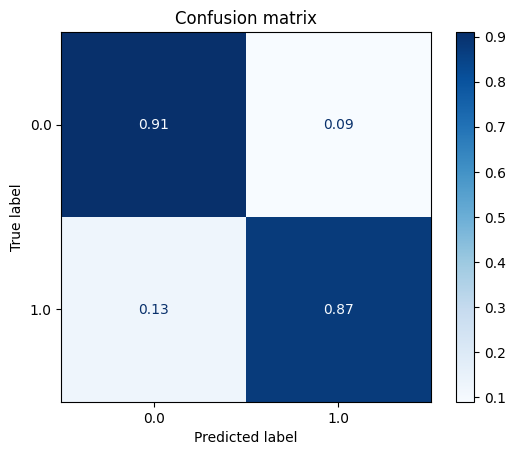

In [ ]:
test(X_test_raw, y_test, model, torch.device('cuda'))

#Conclusions

Based on experiment, it seems that different embeddings (Word2Vec, FastText, GloVe) and different LSTM models (1-directional and bidirectional) did not have a significant impact on accuracy. Perhaps the dataset has a relatively simple structure and the differences between embeddings and LSTMs were not significant enough to affect accuracy.

In addition, various pre-processing methods (cleaning, stemming) also did not significantly affect the accuracy.

The LSTM model performs quite well (with an accuracy of 89.2%), which is close to the baseline model's accuracy (89.97%). We can conclude that the LSTM model is of little value for this task and a simpler model (e.g. logistic regression) may be preferable. It is possible that the LSTM model did not reach its full potential performance due to the lack of hyperparameter tuning.